In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Visualize

In [6]:
import matplotlib.pyplot as plt

def plot_final_version_results(trainer):
    history = trainer.state.log_history
    
    # Extract_Data
    train_loss = [x['loss'] for x in history if 'loss' in x]
    train_steps = [x['step'] for x in history if 'loss' in x]
    
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    eval_r = [x['eval_avg_r'] for x in history if 'eval_avg_r' in x]
    eval_mae = [x['eval_avg_mae'] for x in history if 'eval_avg_mae' in x]
    eval_epochs = [x['epoch'] for x in history if 'eval_loss' in x]

    # Cấu hình giao diện biểu đồ
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle('Model Analysis: Attention Pooling + Sparse MoE', fontsize=16, fontweight='bold')

    # Biểu đồ 1: Loss Convergence (Độ hội tụ)
    axes[0].plot(train_steps, train_loss, label='Train Loss (by step)', color='#3498db', alpha=0.4)
    if eval_epochs:
        steps_per_epoch = max(train_steps) / max(eval_epochs)
        axes[0].plot([e * steps_per_epoch for e in eval_epochs], eval_loss, 
                    label='Val Loss (by epoch)', marker='o', color='#e74c3c', linewidth=2)
    axes[0].set_title('Loss: Overfitting Check')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Biểu đồ 2: Pearson Correlation (Độ tương quan)
    axes[1].plot(eval_epochs, eval_r, marker='s', color='#2ecc71', linewidth=2, label='Avg Pearson R')
    axes[1].set_title('Metric: Pearson R (Higher is better)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('R Score')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Biểu đồ 3: MAE (Sai số tuyệt đối)
    axes[2].plot(eval_epochs, eval_mae, marker='^', color='#f39c12', linewidth=2, label='Avg MAE')
    axes[2].set_title('Metric: MAE (Lower is better)')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Error Value')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('final_version_report.png')
    plt.show()

# 1. Training

>>> [1] Loading & Processing Data...
>>> Loading and Processing Data from /kaggle/input/semevaldataset/Dataset/train_subtask2a.csv...
Total Samples: 2627
Train Samples: 2236 | Test Samples: 391
>>> [2] Tokenizing & Creating Datasets...
>>> [3] Initializing Model...
>>> [4] Starting Training...


Epoch,Training Loss,Validation Loss,R V,Mae V,R A,Mae A,Avg R,Avg Mae
1,0.986500,0.930807,0.197142,1.127513,0.217234,0.780031,0.207188,0.953772
2,0.920100,0.597899,0.545886,1.088587,0.681759,0.595476,0.613822,0.842032
3,0.498700,0.455966,0.571782,0.998058,0.667978,0.562004,0.619880,0.780031
4,0.480200,0.436377,0.568841,1.036172,0.671590,0.571001,0.620216,0.803587
5,0.459200,0.425254,0.577879,1.007490,0.668816,0.576579,0.623348,0.792034
6,0.452000,0.430298,0.577669,1.027538,0.670639,0.584871,0.624154,0.806205
7,0.440500,0.412724,0.578284,1.014497,0.663948,0.589645,0.621116,0.802071
8,0.426800,0.429005,0.577384,1.019629,0.662603,0.589895,0.619994,0.804762


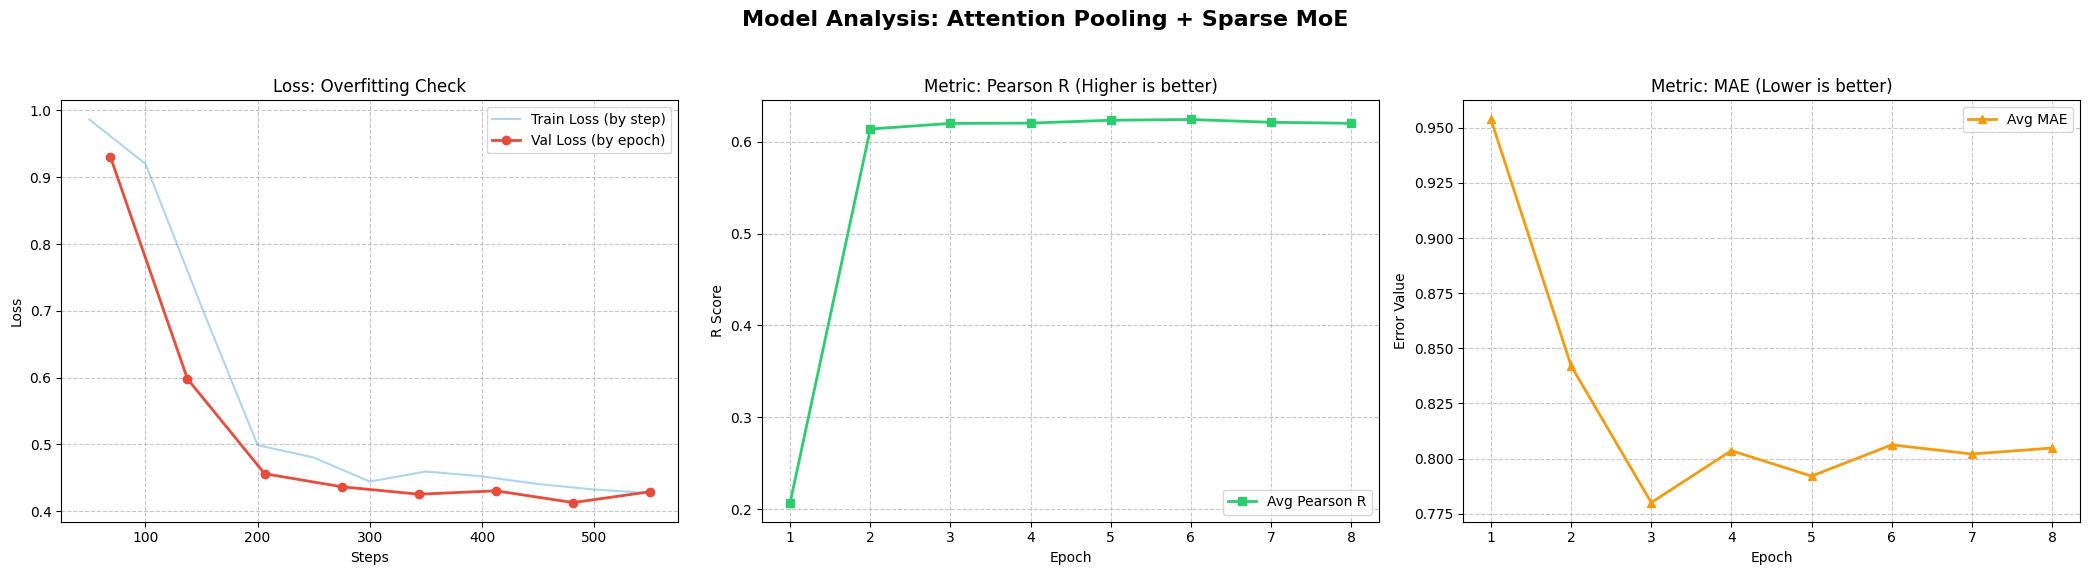

>>> [5] Saving BEST Model for Inference...
>>> [6] Evaluation on Test Set...


RESULTS SUBTASK 2A:
Avg Pearson R: 0.6242
  - Valence R: 0.5777
  - Arousal R: 0.6706
Avg MAE: 0.8062
  - mae Valence: 1.0275
  - mae Arousal: 0.5849


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModel,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    set_seed,DataCollatorWithPadding
)
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import os
import re
import warnings
from typing import Dict, List
import warnings
import shutil
warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ============================================================
# 1. CONFIGURATION
# ============================================================
class Config:
    model_name = {
        "roberta_sentiment": "cardiffnlp/twitter-roberta-base-sentiment-latest"
    }

    train_path = "/kaggle/input/semevaldataset/Dataset/train_subtask2a.csv"
    output_dir = "./semeval_subtask2a_model"

    window_size = 8
    max_seq_length = 512
    per_device_train_batch_size = 16
    gradient_accumulation_steps = 2

    num_train_epochs = 8
    learning_rate = 2e-5
    weight_decay = 0.08
    lr_scheduler_type = "cosine"
    warmup_ratio = 0.1
    logging_steps = 50
    seed = 3407
    max_grad_norm = 1.0

    fp16 = torch.cuda.is_available()
    bf16 = False
    optim = "adamw_torch"
    seed = 3407

set_seed(Config.seed)
# ============================================================
# 2. PREPARE DATA
# ============================================================
def fix_spacing(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+'\s+", "'", text)
    text = re.sub(r"\s+\.", ".", text)
    return text.strip()

def prepare_data(path):

    print(f">>> Loading and Processing Data from {path}...")
    df = pd.read_csv(path)

    # 1. Sắp xếp chuẩn Time-Series
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
    df['text'] = df['text'].apply(fix_spacing)

    new_data = []

    for uid, group in df.groupby('user_id'):
        texts = group['text'].values

        curr_v = group['valence'].values
        curr_a = group['arousal'].values
        #time_logs = group['time_log'].values
        delta_v = group['state_change_valence'].values
        delta_a = group['state_change_arousal'].values

        original_indices = group.index.tolist()

        for i in range(len(texts)):
            # check None thì bỏ qua
            if np.isnan(delta_v[i]) or np.isnan(delta_a[i]):
                continue

            # Creating Sliding Window Text: [Text_i-2, Text_i-1, Text_i]
            window_texts = []
            for k in range(Config.window_size - 1, -1, -1): # k=2, 1, 0
                if i - k >= 0:
                    window_texts.append(str(texts[i-k]))

            # Nối bằng token ngăn cách </s> của RoBERTa
            full_input = " </s> ".join(window_texts)

            new_data.append({
                'user_id': uid,
                'input_text': full_input,
                # Nếu xài thời gian thì thêm time_logs[i] vào
                'numerical_features': [curr_v[i], curr_a[i]],
                'labels': [delta_v[i], delta_a[i]]
            })

        df_new = pd.DataFrame(new_data)
        scaler = StandardScaler()
        nums_matrix = np.array(df_new['numerical_features'].tolist())
        nums_scaled = scaler.fit_transform(nums_matrix)
        df_new['numerical_features'] = nums_scaled.tolist()
    
    return df_new

class EmotionDatasetSubtask2a(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['input_text'].values
        self.nums = np.array(df['numerical_features'].tolist(), dtype=np.float32)
        self.labels = np.array(df['labels'].tolist(), dtype=np.float32)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):

        text = self.texts[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=Config.max_seq_length,
            return_tensors="pt"
        )

        return {
            "input_ids" : enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'numerical_features': torch.tensor(self.nums[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# ============================================================
# 3. CUSTOM Model
# ============================================================

class CCCLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        mu_pred = torch.mean(y_pred)
        mu_true = torch.mean(y_true)

        var_pred = torch.var(y_pred, unbiased=False)
        var_true = torch.var(y_true, unbiased=False)

        covariance = torch.mean((y_pred - mu_pred) * (y_true - mu_true))

        numerator = 2 * covariance
        denominator = var_pred + var_true + (mu_pred - mu_true)**2 + self.eps

        return 1.0 - (numerator / denominator)


class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, 1)
        )

    def forward(self, last_hidden_state, attention_mask):
        # last_hidden_state: [Batch, Seq, Hidden]

        # 1. "raw score" for each token
        w = self.attention(last_hidden_state) # [Batch, Seq, 1]

        # 2. Masking 
        # w.squeeze(-1) -> [Batch, Seq]
        w = w.squeeze(-1).masked_fill(attention_mask == 0, -1e4)

        # 3. Softmax 
        weights = torch.softmax(w, dim=1).unsqueeze(-1) # [Batch, Seq, 1]

        # 4. Weighted Sum
        context_vector = torch.sum(weights * last_hidden_state, dim=1) # [Batch, Hidden]

        return context_vector


class Expert(nn.Module):
    """a lonely expert"""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class SparseMoELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts=4, top_k=2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.gate = nn.Linear(input_dim, num_experts)
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)
        ])

    def forward(self, x):
        gate_logits = self.gate(x)
        gate_probs = F.softmax(gate_logits, dim=-1)

        # Top-K Selection
        topk_weights, topk_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)

        all_expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        batch_size = x.size(0)
        final_output = torch.zeros(batch_size, 1, device=x.device)

        # Gather Top-K Results
        for k in range(self.top_k):
            expert_idx = topk_indices[:, k]
            weight = topk_weights[:, k].unsqueeze(1)
            idx_view = expert_idx.view(-1, 1, 1).expand(-1, 1, all_expert_outputs.size(-1))
            selected_output = all_expert_outputs.gather(1, idx_view).squeeze(1)
            final_output += weight * selected_output

        return final_output


class Subtask2aModel(nn.Module):
    def __init__(self, model_name, num_experts=4, top_k=2):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.config.hidden_size
        fusion_dim = hidden_size + 2

        # 1. ATTENTION POOLING
        self.pooler = AttentionPooling(hidden_size)

        # 2. SPARSE MOE HEADS
        self.valence_moe = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)
        self.arousal_moe = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)

        self.loss_fct = CCCLoss()

        # Init weights
        self._init_weights(self.pooler)
        self._init_weights(self.valence_moe)
        self._init_weights(self.arousal_moe)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
             if module.bias is not None: module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
             module.bias.data.zero_()
             module.weight.data.fill_(1.0)
        elif isinstance(module, (nn.ModuleList, nn.Sequential)):
             for sub in module: self._init_weights(sub)
        elif isinstance(module, SparseMoELayer):
            self._init_weights(module.gate)
            self._init_weights(module.experts)
        elif isinstance(module, Expert):
            self._init_weights(module.net)
        elif isinstance(module, AttentionPooling):
            self._init_weights(module.attention)

    def forward(self, input_ids, attention_mask,numerical_features, labels=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        
        text_feature = self.pooler(outputs.last_hidden_state, attention_mask)
        
        combined_features = torch.cat((text_feature, numerical_features), dim=1)

        val_pred = self.valence_moe(combined_features)
        aro_pred = self.arousal_moe(combined_features)
        logits = torch.cat((val_pred, aro_pred), dim=1)

        loss = None
        if labels is not None:
            loss_v = self.loss_fct(val_pred, labels[:, 0])
            loss_a = self.loss_fct(aro_pred, labels[:, 1])
            loss = 0.5 * loss_v + 0.5 * loss_a

        return {"loss": loss, "logits": logits}

#===============
# METRICS
#===============

def compute_metrics_subtask2a(eval_pred):
    """Cal metrics for Subtask 2a"""
    predictions, labels = eval_pred
    if isinstance(predictions, tuple): predictions = predictions[0]

    pred_v = predictions[:, 0]
    pred_a = predictions[:, 1]
    lab_v = labels[:, 0]
    lab_a = labels[:, 1]

    def _pearson(x, y):
        if len(x) < 2: return 0.0
        if np.var(x) == 0 or np.var(y) == 0: return 0.0
        r, _ = pearsonr(x, y)
        return r

    def _mae(x, y):
        return np.mean(np.abs(x - y))

    r_v = _pearson(pred_v, lab_v)
    mae_v = _mae(pred_v, lab_v)
    r_a = _pearson(pred_a, lab_a)
    mae_a = _mae(pred_a, lab_a)

    avg_r = (r_v + r_a) / 2
    avg_mae = (mae_a + mae_v) / 2 
    return {
        "r_v": r_v, "mae_v": mae_v,
        "r_a": r_a, "mae_a": mae_a,
        "avg_r": avg_r, "avg_mae" : avg_mae
    }

def train_model():
    print(">>> [1] Loading & Processing Data...")

    if not os.path.exists(Config.train_path):
        print(f"ERROR: File not found at {Config.train_path}")
        return

    # Load & Prepare Data
    df_processed = prepare_data(Config.train_path)

    # Split Train/Test (Group Shuffle Split)
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=Config.seed)
    train_idx, test_idx = next(splitter.split(df_processed, groups=df_processed['user_id']))

    print(f"Total Samples: {len(df_processed)}")
    print(f"Train Samples: {len(train_idx)} | Test Samples: {len(test_idx)}")

    print(">>> [2] Tokenizing & Creating Datasets...")
    tokenizer = AutoTokenizer.from_pretrained(Config.model_name['roberta_sentiment'])

    # Tạo Dataset từ DataFrame đã chia
    train_ds = EmotionDatasetSubtask2a(df_processed.iloc[train_idx], tokenizer)
    test_ds = EmotionDatasetSubtask2a(df_processed.iloc[test_idx], tokenizer)

    print(">>> [3] Initializing Model...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Subtask2aModel(Config.model_name['roberta_sentiment']).to(device)

    # Args
    training_args = TrainingArguments(
        output_dir=Config.output_dir,
        learning_rate=Config.learning_rate,
        per_device_train_batch_size=Config.per_device_train_batch_size,
        per_device_eval_batch_size=Config.per_device_train_batch_size * 2,
        gradient_accumulation_steps=Config.gradient_accumulation_steps,

        num_train_epochs=Config.num_train_epochs,
        warmup_ratio=Config.warmup_ratio,

        # Speed Optimization
        group_by_length=True,
        dataloader_num_workers=2,

        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="avg_r",
        greater_is_better=True,

        fp16=Config.fp16,
        save_total_limit=1,
        remove_unused_columns=False,

        report_to="none",
        logging_steps=Config.logging_steps,

        weight_decay=Config.weight_decay,
        lr_scheduler_type=Config.lr_scheduler_type,
        max_grad_norm=Config.max_grad_norm,
        optim=Config.optim,

        save_safetensors=True,
        seed=Config.seed
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics_subtask2a,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    print(">>> [4] Starting Training...")
    trainer.train()
    plot_final_version_results(trainer)

    print(">>> [5] Saving BEST Model for Inference...")
    save_path = "./final_subtask2a_model"
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)
    
    model.config.save_pretrained(save_path)
    trainer.save_state()
    # Zip model to download
    try:
        shutil.make_archive("/kaggle/working/final_subtask2a_model", 'zip', out_path)
        print("Zipped to final_model.zip")
    except: pass

    print(">>> [6] Evaluation on Test Set...")
    eval_metrics = trainer.evaluate(test_ds)
    
    print("=" * 40)
    print(f"RESULTS SUBTASK 2A:")
    print(f"Avg Pearson R: {eval_metrics['eval_avg_r']:.4f}")
    print(f"  - Valence R: {eval_metrics['eval_r_v']:.4f}")
    print(f"  - Arousal R: {eval_metrics['eval_r_a']:.4f}")
    print(f"Avg MAE: {eval_metrics['eval_avg_mae']:.4f}")
    print(f"  - mae Valence: {eval_metrics['eval_mae_v']:.4f}")
    print(f"  - mae Arousal: {eval_metrics['eval_mae_a']:.4f}")
    print("=" * 40)

if __name__ == "__main__":
    train_model()

# 2. Inference + Submission

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModel
from sklearn.preprocessing import StandardScaler
import os
import re
from tqdm import tqdm
try:
    from safetensors.torch import load_file as safe_load_file
except ImportError:
    print("Warning: 'safetensors' not installed. If using .safetensors file, please install it.")

# ============================================================
# 1. CONFIGURATION
# ============================================================
class Config:
    base_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

    model_output_dir = "./final_subtask2a_model"
    
    weights_file_name = "model.safetensors" 
    
    train_path = "/kaggle/input/semevaldataset/Dataset/train_subtask2a.csv"
    test_path = "/kaggle/input/semevaldataset/Dataset/TEST_RELEASE_5JAN2026/subtask2a_forecasting_user_marker.csv"
    
    output_file = "pred_subtask2a.csv"
    
    window_size = 8
    max_seq_length = 512
    batch_size = 32
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # MoE Config
    num_experts = 4
    top_k = 2

# ============================================================
# 2. MODEL DEFINITION (SPARSE MOE + ATTENTION POOLING)
# ============================================================
class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, 1)
        )

    def forward(self, last_hidden_state, attention_mask):
        # last_hidden_state: [Batch, Seq, Hidden]
        w = self.attention(last_hidden_state) 
        w = w.squeeze(-1).masked_fill(attention_mask == 0, -1e4)
        weights = torch.softmax(w, dim=1).unsqueeze(-1)
        context_vector = torch.sum(weights * last_hidden_state, dim=1)
        return context_vector

class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x): return self.net(x)

class SparseMoELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts=4, top_k=2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.gate = nn.Linear(input_dim, num_experts)
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)
        ])

    def forward(self, x):
        gate_logits = self.gate(x)
        gate_probs = F.softmax(gate_logits, dim=-1)

        # Top-K Selection
        topk_weights, topk_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)

        all_expert_outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        batch_size = x.size(0)
        final_output = torch.zeros(batch_size, 1, device=x.device)

        for k in range(self.top_k):
            expert_idx = topk_indices[:, k]
            weight = topk_weights[:, k].unsqueeze(1)
            idx_view = expert_idx.view(-1, 1, 1).expand(-1, 1, all_expert_outputs.size(-1))
            selected_output = all_expert_outputs.gather(1, idx_view).squeeze(1)
            final_output += weight * selected_output

        return final_output

class Subtask2aModel(nn.Module):
    def __init__(self, model_name, num_experts=4, top_k=2):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.config.hidden_size
        fusion_dim = hidden_size + 2

        # 1. ATTENTION POOLING
        self.pooler = AttentionPooling(hidden_size)

        # 2. SPARSE MOE HEADS
        self.valence_moe = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)
        self.arousal_moe = SparseMoELayer(fusion_dim, 256, 1, num_experts, top_k)

    def forward(self, input_ids, attention_mask, numerical_features):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        
        # Attention Pooling thay vì Mean Pooling
        text_feature = self.pooler(outputs.last_hidden_state, attention_mask)
        
        combined_features = torch.cat((text_feature, numerical_features), dim=1)

        val_pred = self.valence_moe(combined_features)
        aro_pred = self.arousal_moe(combined_features)
        
        return val_pred, aro_pred

# ============================================================
# 3. DATA PROCESSING
# ============================================================
def fix_spacing(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+'\s+", "'", text)
    text = re.sub(r"\s+\.", ".", text)
    return text.strip()

def process_dataframe_for_inference(df_path, is_train=False):
    print(f"Processing {df_path}...")
    df = pd.read_csv(df_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    has_forecasting_marker = 'is_forecasting_user' in df.columns
    
    df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
    df['text'] = df['text'].apply(fix_spacing)
    
    processed_data = []
    
    for uid, group in df.groupby('user_id'):
        texts = group['text'].values
        curr_v = group['valence'].values
        curr_a = group['arousal'].values
        
        if is_train:
            for i in range(len(texts)):
                processed_data.append({'numerical_features': [curr_v[i], curr_a[i]]})
        
        else:
            target_indices = []
            if has_forecasting_marker:
                is_true = group['is_forecasting_user'].values
                if 'state_change_valence' in group.columns:
                    is_nan = np.isnan(group['state_change_valence'].values)
                    target_indices = np.where(is_true & is_nan)[0].tolist()
                else:
                    true_indices = np.where(is_true)[0]
                    if len(true_indices) > 0:
                        target_indices = [true_indices[-1]]
            else:
                # Fallback
                target_indices = [len(texts) - 1]

            for idx in target_indices:
                window_texts = []
                for k in range(Config.window_size - 1, -1, -1):
                    i = idx - k
                    if i >= 0:
                        window_texts.append(str(texts[i]))
                full_input = " </s> ".join(window_texts)
                
                processed_data.append({
                    'user_id': uid, 
                    'input_text': full_input,
                    'numerical_features': [curr_v[idx], curr_a[idx]]
                })
            
    return pd.DataFrame(processed_data)

class InferenceDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['input_text'].values
        self.nums = np.array(df['numerical_features'].tolist(), dtype=np.float32)
        self.tokenizer = tokenizer

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx], truncation=True, padding="max_length",
            max_length=Config.max_seq_length, return_tensors="pt"
        )
        return {
            "input_ids" : enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'numerical_features': torch.tensor(self.nums[idx], dtype=torch.float)
        }

# ============================================================
# 4. MAIN INFERENCE
# ============================================================
def predict():
    print(">>> [1] Fitting Scaler on TRAINING Data...")
    train_proc = process_dataframe_for_inference(Config.train_path, is_train=True)
    scaler = StandardScaler()
    scaler.fit(np.array(train_proc['numerical_features'].tolist())) 

    print(">>> [2] Processing TEST Data...")
    test_proc = process_dataframe_for_inference(Config.test_path, is_train=False)
    test_nums_scaled = scaler.transform(np.array(test_proc['numerical_features'].tolist()))
    test_proc['numerical_features'] = test_nums_scaled.tolist()
    
    print(f"Unique Predictions to make: {len(test_proc)}")

    print(">>> [3] Loading Model...")
    tokenizer = AutoTokenizer.from_pretrained(Config.base_model_name)
    
    # Khởi tạo model với kiến trúc MoE
    model = Subtask2aModel(Config.base_model_name, num_experts=Config.num_experts, top_k=Config.top_k)
    
    weights_path = os.path.join(Config.model_output_dir, Config.weights_file_name)
    
    if os.path.exists(weights_path):
        print(f"Loading weights from {weights_path}...")
        
        # Tự động chọn cách load
        if weights_path.endswith(".safetensors"):
            state_dict = safe_load_file(weights_path, device="cpu")
        else:
            state_dict = torch.load(weights_path, map_location="cpu", weights_only=False)
            
        # strict=False để tránh lỗi nếu có sai khác nhỏ về tên layer (thường không sao)
        model.load_state_dict(state_dict, strict=False)
        print("Model weights loaded successfully!")
    else:
        print(f"ERROR: File not found: {weights_path}")
        return

    model.to(Config.device)
    model.eval()

    print(">>> [4] Running Inference...")
    test_ds = InferenceDataset(test_proc, tokenizer)
    test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2)

    val_preds = []
    aro_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(Config.device)
            attention_mask = batch['attention_mask'].to(Config.device)
            numerical_features = batch['numerical_features'].to(Config.device)

            p_val, p_aro = model(input_ids, attention_mask, numerical_features)
            val_preds.extend(p_val.cpu().numpy().flatten())
            aro_preds.extend(p_aro.cpu().numpy().flatten())

    print(">>> [5] Creating Submission File...")
    submission = pd.DataFrame({
        'user_id': test_proc['user_id'],
        'pred_state_change_valence': val_preds,
        'pred_state_change_arousal': aro_preds
    })
    
    submission.to_csv(Config.output_file, index=False)
    print(f"Done! Submission saved to: {Config.output_file}")
    print(submission.head())

if __name__ == "__main__":
    predict()

>>> [1] Fitting Scaler on TRAINING Data...
Processing /kaggle/input/semevaldataset/Dataset/train_subtask2a.csv...
>>> [2] Processing TEST Data...
Processing /kaggle/input/semevaldataset/Dataset/TEST_RELEASE_5JAN2026/subtask2a_forecasting_user_marker.csv...
Unique Predictions to make: 46
>>> [3] Loading Model...
Loading weights from ./final_subtask2a_model/model.safetensors...
Model weights loaded successfully!
>>> [4] Running Inference...


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

>>> [5] Creating Submission File...
Done! Submission saved to: pred_subtask2a.csv
   user_id  pred_state_change_valence  pred_state_change_arousal
0        6                   0.733413                  -1.244618
1        8                  -1.234195                   0.710250
2       11                   1.078990                   0.063822
3       16                   0.139311                  -0.409643
4       21                  -1.338789                  -0.133164


In [11]:
# Nén thư mục 'final_subtask2a_model' thành file 'submission_s2a.zip'
!zip -r submission_s2a.zip /kaggle/working/final_subtask2a_model

  adding: kaggle/working/final_subtask2a_model/ (stored 0%)
  adding: kaggle/working/final_subtask2a_model/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/final_subtask2a_model/vocab.json (deflated 59%)
  adding: kaggle/working/final_subtask2a_model/training_args.bin (deflated 53%)
  adding: kaggle/working/final_subtask2a_model/special_tokens_map.json (deflated 84%)
  adding: kaggle/working/final_subtask2a_model/config.json (deflated 51%)
  adding: kaggle/working/final_subtask2a_model/model.safetensors (deflated 7%)
  adding: kaggle/working/final_subtask2a_model/merges.txt (deflated 53%)
  adding: kaggle/working/final_subtask2a_model/tokenizer.json (deflated 82%)
